In [39]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#from ncon import ncon
from tensornetwork.ncon_interface import ncon
from doDMRG_MPO_comm_real import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *

In [40]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [41]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [42]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [43]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [44]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [45]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [46]:
def ground_state():
    #print('h =',h)
    global chi
    
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    c=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    c.append(-2)
    
    M1=[]
    for i in range(N):
        M1.append(MM1)
    Marr.append(M1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    c.append(1)
    
    M2=[]
    for i in range(N):
        M2.append(MM2)
    Marr.append(M2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    c.append(1)
    
    M3=[]
    for i in range(N):
        M3.append(MM3) 
    Marr.append(M3)
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ
    
    ML4 = np.ones((1,1,1))
    MR4 = np.ones((1,1,1))
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk4 = np.zeros((1,1,4,4))
    Mbulk4[0,0,:,:] = np.eye(4)
    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(1,1,chid,chid)
    c.append(-2)
    
    M4=[]
    for i in range(N-1):
        M4.append(Mbulk4)
    M4.append(MM4)
    Marr.append(M4)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk5 = Mbulk4
    MM5 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(1,1,chid,chid)
    c.append(1)
    
    M5=[]
    for i in range(N-1):
        M5.append(Mbulk5)
    M5.append(MM5)
    Marr.append(M5)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk6 = Mbulk4
    MM6 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(1,1,chid,chid)
    c.append(1)
    
    M6=[]
    for i in range(N-1):
        M6.append(Mbulk6)
    M6.append(MM6)
    Marr.append(M6)
    
    
    
    Mbulk7 = ncon([iden,iden],[[-1,-2],[-3,-4]]).reshape(1,1,chid,chid)
    MLarr.append(ML4)
    MRarr.append(MR4)
    c.append(100)
    
    M7=[]
    for i in range(N):
        M7.append(Mbulk7)
    Marr.append(M7)
    
    
    
    
    
    
    
    chi = 4
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))
    
    En=[]
    
    
    for i in range(5):
        #### Do DMRG sweeps (2-site approach)
        Enn, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        print('Minimal value of the functional: ', np.real(Enn[len(Enn)-1]))
        #print(Enn)
        print()
        En.append(Enn)
        chi *= 2
        printentrlocdensmatr(A)
    
    
    #for i in range(N):
        #print(A[i].shape)
    #print("*")
    #for i in range(N):
        #print(B[i].shape)
    
    #print('A=')
    #print(A)
    return (En[len(En)-1][len(En[len(En)-1])-1],A)

In [47]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [48]:
def printentrlocdensmatr(m):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        print('Position = ', i,': ',entrloc[i])
    
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'bs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [49]:
def CalculateEnergy():
    global h
    global g
    global N
    g=1.05
    print('g =',g)
    print('h =',h)
    print()
    E=[]
    for N in range(5,9,3):
        print('The length of the Ising spin chain N =',N)
        Ecur, A = ground_state()
        print('Mininimal value of the functional')
        print(np.around(np.real(Ecur),decimals=acc))
        print()
        E.append(np.around(np.real(Ecur),decimals=acc))
        
        
        
    """
    t=np.arange(8,9)
    
    #fig = go.Figure(data=[go.Table(header=dict(values=['h', 'Energy']),
                 #cells=dict(values=[t, E]))
                     #])
    #fig.show()
    
    
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, E, 'bs')
    plt.legend()
    plt.xlabel("The length of the Ising spin chain N", fontsize=20)
    plt.ylabel("Mininimal value of the functional", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    """

H = - ZZ + hZ + gX
g = 1.05
h = 0.5

The length of the Ising spin chain N = 5
Sweep: 1 of 30, Energy: 0.509867, Bond dim: 4
Sweep: 2 of 30, Energy: 0.288839, Bond dim: 4
Sweep: 3 of 30, Energy: 0.198204, Bond dim: 4
Sweep: 4 of 30, Energy: 0.154468, Bond dim: 4
Sweep: 5 of 30, Energy: 0.132729, Bond dim: 4
Sweep: 6 of 30, Energy: 0.119636, Bond dim: 4
Sweep: 7 of 30, Energy: 0.110436, Bond dim: 4
Sweep: 8 of 30, Energy: 0.103196, Bond dim: 4
Sweep: 9 of 30, Energy: 0.097161, Bond dim: 4
Sweep: 10 of 30, Energy: 0.092221, Bond dim: 4
Sweep: 11 of 30, Energy: 0.088459, Bond dim: 4
Sweep: 12 of 30, Energy: 0.085596, Bond dim: 4
Sweep: 13 of 30, Energy: 0.083395, Bond dim: 4
Sweep: 14 of 30, Energy: 0.081688, Bond dim: 4
Sweep: 15 of 30, Energy: 0.080352, Bond dim: 4
Sweep: 16 of 30, Energy: 0.079296, Bond dim: 4
Sweep: 17 of 30, Energy: 0.078455, Bond dim: 4
Sweep: 18 of 30, Energy: 0.077780, Bond dim: 4
Sweep: 19 of 30, Energy: 0.077234, Bond dim: 4
Sweep: 20 of 30, Energy: 0.076791, Bon

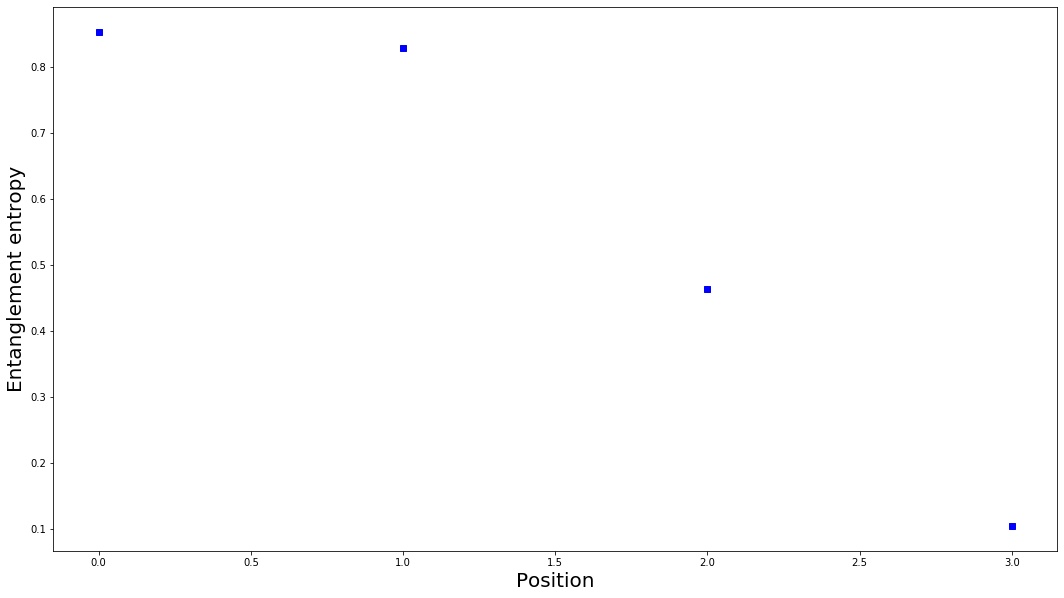

Sweep: 1 of 30, Energy: 0.066708, Bond dim: 8
Sweep: 2 of 30, Energy: 0.065306, Bond dim: 8
Sweep: 3 of 30, Energy: 0.064888, Bond dim: 8
Sweep: 4 of 30, Energy: 0.064717, Bond dim: 8
Sweep: 5 of 30, Energy: 0.064634, Bond dim: 8
Sweep: 6 of 30, Energy: 0.064587, Bond dim: 8
Sweep: 7 of 30, Energy: 0.064559, Bond dim: 8
Sweep: 8 of 30, Energy: 0.064540, Bond dim: 8
Sweep: 9 of 30, Energy: 0.064528, Bond dim: 8
Sweep: 10 of 30, Energy: 0.064519, Bond dim: 8
Sweep: 11 of 30, Energy: 0.064512, Bond dim: 8
Sweep: 12 of 30, Energy: 0.064507, Bond dim: 8
Sweep: 13 of 30, Energy: 0.064503, Bond dim: 8
Sweep: 14 of 30, Energy: 0.064499, Bond dim: 8
Sweep: 15 of 30, Energy: 0.064496, Bond dim: 8
Sweep: 16 of 30, Energy: 0.064494, Bond dim: 8
Sweep: 17 of 30, Energy: 0.064491, Bond dim: 8
Sweep: 18 of 30, Energy: 0.064488, Bond dim: 8
Sweep: 19 of 30, Energy: 0.064484, Bond dim: 8
Sweep: 20 of 30, Energy: 0.064476, Bond dim: 8
Sweep: 21 of 30, Energy: 0.064442, Bond dim: 8
Sweep: 22 of 30, Energ

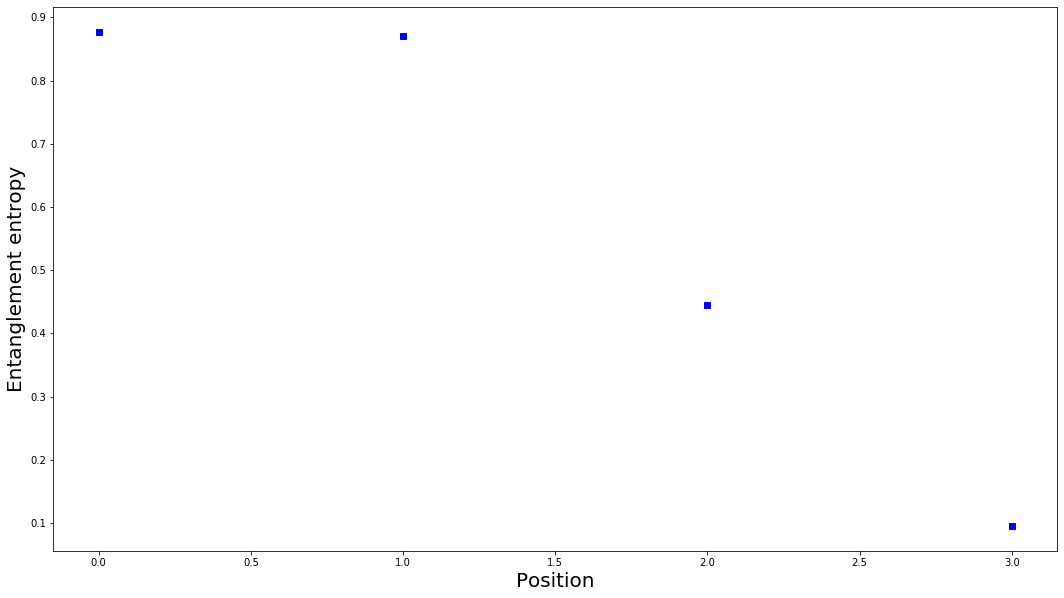

Sweep: 1 of 30, Energy: 0.060262, Bond dim: 16
Sweep: 2 of 30, Energy: 0.059434, Bond dim: 16
Sweep: 3 of 30, Energy: 0.059045, Bond dim: 16
Sweep: 4 of 30, Energy: 0.058814, Bond dim: 16
Sweep: 5 of 30, Energy: 0.058667, Bond dim: 16
Sweep: 6 of 30, Energy: 0.058569, Bond dim: 16
Sweep: 7 of 30, Energy: 0.058502, Bond dim: 16
Sweep: 8 of 30, Energy: 0.058453, Bond dim: 16
Sweep: 9 of 30, Energy: 0.058418, Bond dim: 16
Sweep: 10 of 30, Energy: 0.058391, Bond dim: 16
Sweep: 11 of 30, Energy: 0.058370, Bond dim: 16
Sweep: 12 of 30, Energy: 0.058353, Bond dim: 16
Sweep: 13 of 30, Energy: 0.058340, Bond dim: 16
Sweep: 14 of 30, Energy: 0.058329, Bond dim: 16
Sweep: 15 of 30, Energy: 0.058320, Bond dim: 16
Sweep: 16 of 30, Energy: 0.058312, Bond dim: 16
Sweep: 17 of 30, Energy: 0.058306, Bond dim: 16
Sweep: 18 of 30, Energy: 0.058301, Bond dim: 16
Sweep: 19 of 30, Energy: 0.058296, Bond dim: 16
Sweep: 20 of 30, Energy: 0.058292, Bond dim: 16
Sweep: 21 of 30, Energy: 0.058289, Bond dim: 16
S

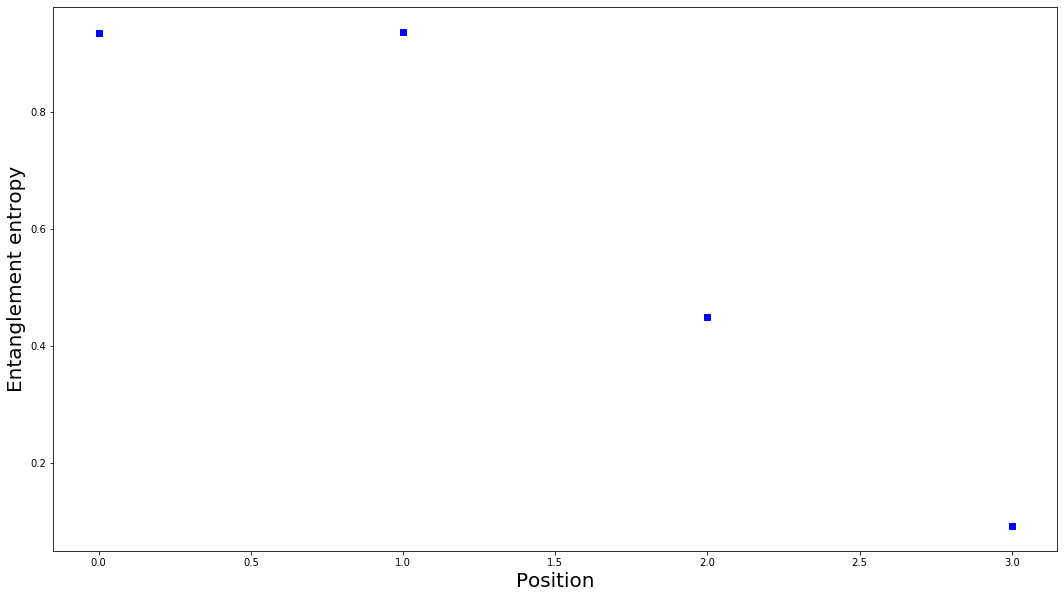

Sweep: 1 of 30, Energy: 0.058272, Bond dim: 32
Sweep: 2 of 30, Energy: 0.058272, Bond dim: 32
Sweep: 3 of 30, Energy: 0.058271, Bond dim: 32
Sweep: 4 of 30, Energy: 0.058271, Bond dim: 32
Sweep: 5 of 30, Energy: 0.058270, Bond dim: 32
Sweep: 6 of 30, Energy: 0.058270, Bond dim: 32
Sweep: 7 of 30, Energy: 0.058269, Bond dim: 32
Sweep: 8 of 30, Energy: 0.058269, Bond dim: 32
Sweep: 9 of 30, Energy: 0.058269, Bond dim: 32
Sweep: 10 of 30, Energy: 0.058269, Bond dim: 32
Sweep: 11 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 12 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 13 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 14 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 15 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 16 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 17 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 18 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 19 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 20 of 30, Energy: 0.058268, Bond dim: 32
Sweep: 21 of 30, Energy: 0.058268, Bond dim: 32
S

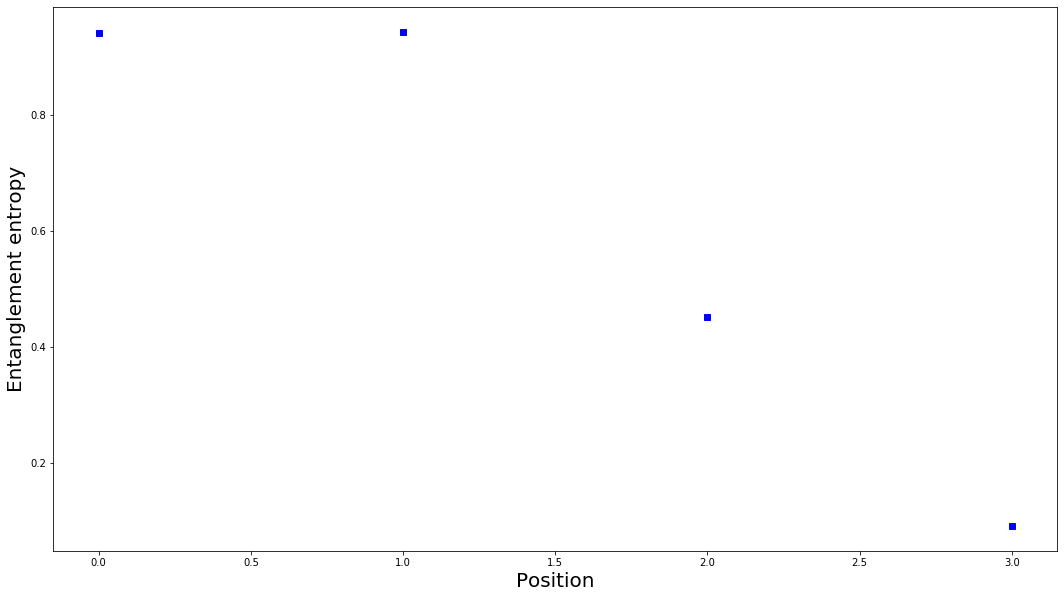

Sweep: 1 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 2 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 3 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 4 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 5 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 6 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 7 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 8 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 9 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 10 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 11 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 12 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 13 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 14 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 15 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 16 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 17 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 18 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 19 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 20 of 30, Energy: 0.058267, Bond dim: 64
Sweep: 21 of 30, Energy: 0.058267, Bond dim: 64
S

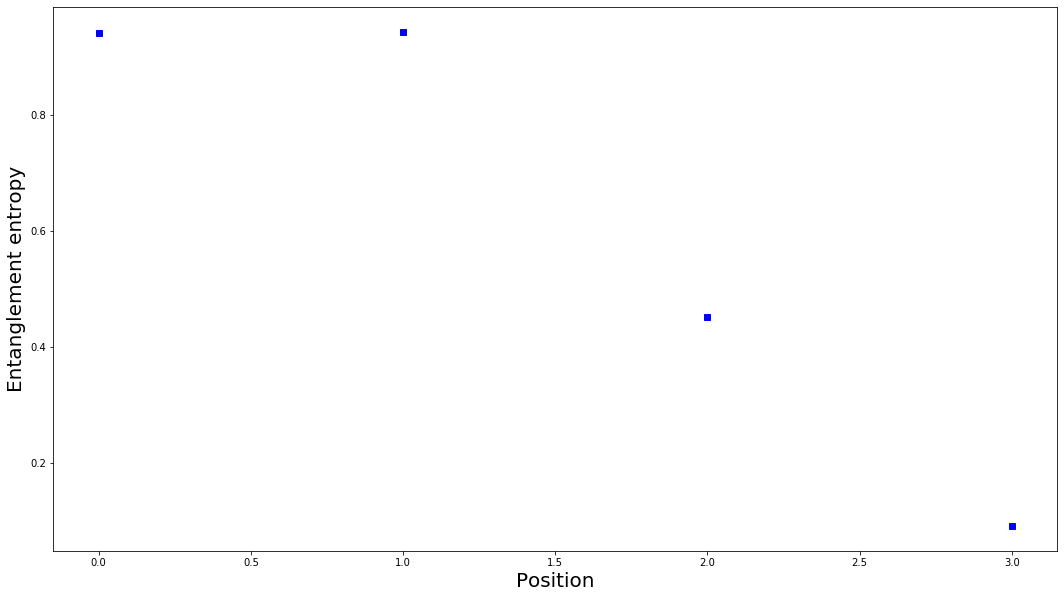

Mininimal value of the functional
0.05826733883759106

The length of the Ising spin chain N = 8
Sweep: 1 of 30, Energy: 0.718414, Bond dim: 4
Sweep: 2 of 30, Energy: 0.437141, Bond dim: 4
Sweep: 3 of 30, Energy: 0.320082, Bond dim: 4
Sweep: 4 of 30, Energy: 0.246541, Bond dim: 4
Sweep: 5 of 30, Energy: 0.188988, Bond dim: 4
Sweep: 6 of 30, Energy: 0.150155, Bond dim: 4
Sweep: 7 of 30, Energy: 0.125849, Bond dim: 4
Sweep: 8 of 30, Energy: 0.108579, Bond dim: 4
Sweep: 9 of 30, Energy: 0.095599, Bond dim: 4
Sweep: 10 of 30, Energy: 0.085572, Bond dim: 4
Sweep: 11 of 30, Energy: 0.077092, Bond dim: 4
Sweep: 12 of 30, Energy: 0.070200, Bond dim: 4
Sweep: 13 of 30, Energy: 0.065086, Bond dim: 4
Sweep: 14 of 30, Energy: 0.060956, Bond dim: 4
Sweep: 15 of 30, Energy: 0.057477, Bond dim: 4
Sweep: 16 of 30, Energy: 0.054322, Bond dim: 4
Sweep: 17 of 30, Energy: 0.051250, Bond dim: 4
Sweep: 18 of 30, Energy: 0.048463, Bond dim: 4
Sweep: 19 of 30, Energy: 0.046163, Bond dim: 4
Sweep: 20 of 30, Ene

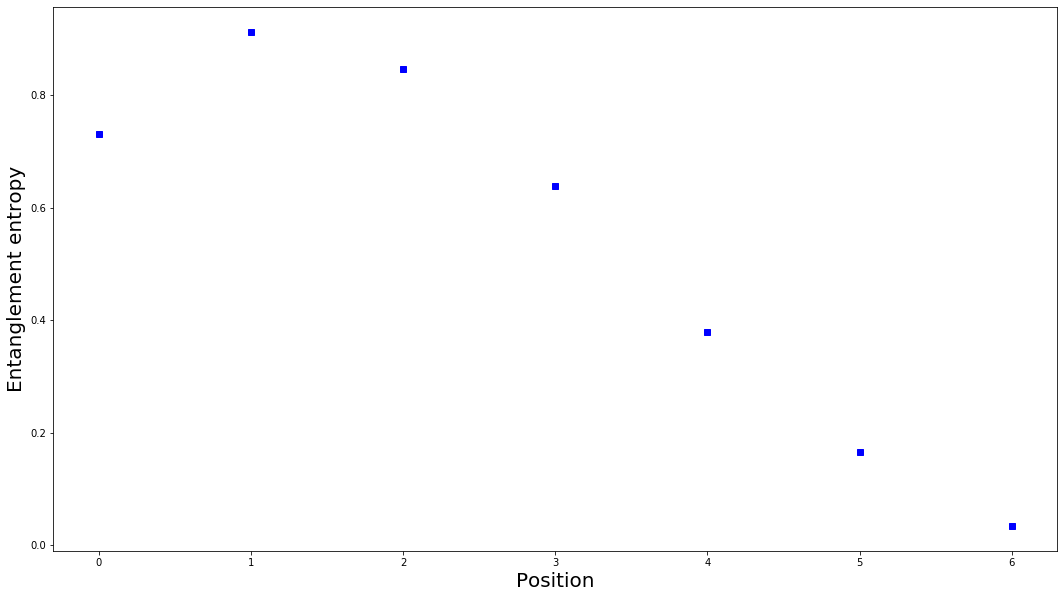

Sweep: 1 of 30, Energy: 0.029811, Bond dim: 8
Sweep: 2 of 30, Energy: 0.028567, Bond dim: 8
Sweep: 3 of 30, Energy: 0.027920, Bond dim: 8
Sweep: 4 of 30, Energy: 0.027510, Bond dim: 8
Sweep: 5 of 30, Energy: 0.027215, Bond dim: 8
Sweep: 6 of 30, Energy: 0.026975, Bond dim: 8
Sweep: 7 of 30, Energy: 0.026756, Bond dim: 8
Sweep: 8 of 30, Energy: 0.026553, Bond dim: 8
Sweep: 9 of 30, Energy: 0.026384, Bond dim: 8
Sweep: 10 of 30, Energy: 0.026235, Bond dim: 8
Sweep: 11 of 30, Energy: 0.026099, Bond dim: 8
Sweep: 12 of 30, Energy: 0.025975, Bond dim: 8
Sweep: 13 of 30, Energy: 0.025860, Bond dim: 8
Sweep: 14 of 30, Energy: 0.025751, Bond dim: 8
Sweep: 15 of 30, Energy: 0.025649, Bond dim: 8
Sweep: 16 of 30, Energy: 0.025552, Bond dim: 8
Sweep: 17 of 30, Energy: 0.025460, Bond dim: 8
Sweep: 18 of 30, Energy: 0.025373, Bond dim: 8
Sweep: 19 of 30, Energy: 0.025291, Bond dim: 8
Sweep: 20 of 30, Energy: 0.025214, Bond dim: 8
Sweep: 21 of 30, Energy: 0.025141, Bond dim: 8
Sweep: 22 of 30, Energ

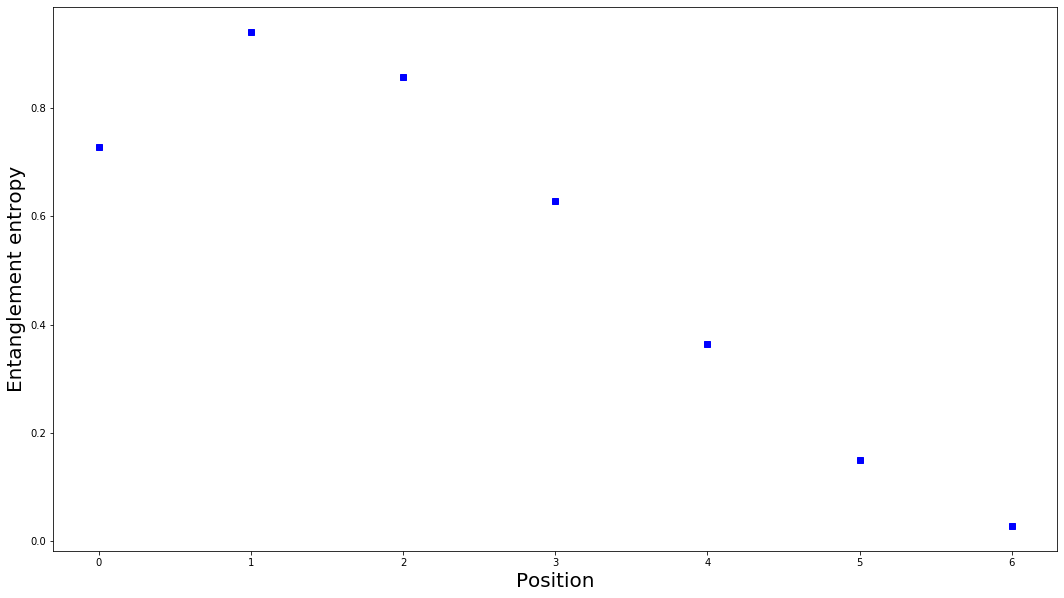

Sweep: 1 of 30, Energy: 0.022732, Bond dim: 16
Sweep: 2 of 30, Energy: 0.022232, Bond dim: 16
Sweep: 3 of 30, Energy: 0.021988, Bond dim: 16
Sweep: 4 of 30, Energy: 0.021841, Bond dim: 16
Sweep: 5 of 30, Energy: 0.021732, Bond dim: 16
Sweep: 6 of 30, Energy: 0.021645, Bond dim: 16
Sweep: 7 of 30, Energy: 0.021573, Bond dim: 16
Sweep: 8 of 30, Energy: 0.021511, Bond dim: 16
Sweep: 9 of 30, Energy: 0.021457, Bond dim: 16
Sweep: 10 of 30, Energy: 0.021409, Bond dim: 16
Sweep: 11 of 30, Energy: 0.021366, Bond dim: 16
Sweep: 12 of 30, Energy: 0.021326, Bond dim: 16
Sweep: 13 of 30, Energy: 0.021293, Bond dim: 16
Sweep: 14 of 30, Energy: 0.021264, Bond dim: 16
Sweep: 15 of 30, Energy: 0.021238, Bond dim: 16
Sweep: 16 of 30, Energy: 0.021214, Bond dim: 16
Sweep: 17 of 30, Energy: 0.021193, Bond dim: 16
Sweep: 18 of 30, Energy: 0.021173, Bond dim: 16
Sweep: 19 of 30, Energy: 0.021155, Bond dim: 16
Sweep: 20 of 30, Energy: 0.021138, Bond dim: 16
Sweep: 21 of 30, Energy: 0.021122, Bond dim: 16
S

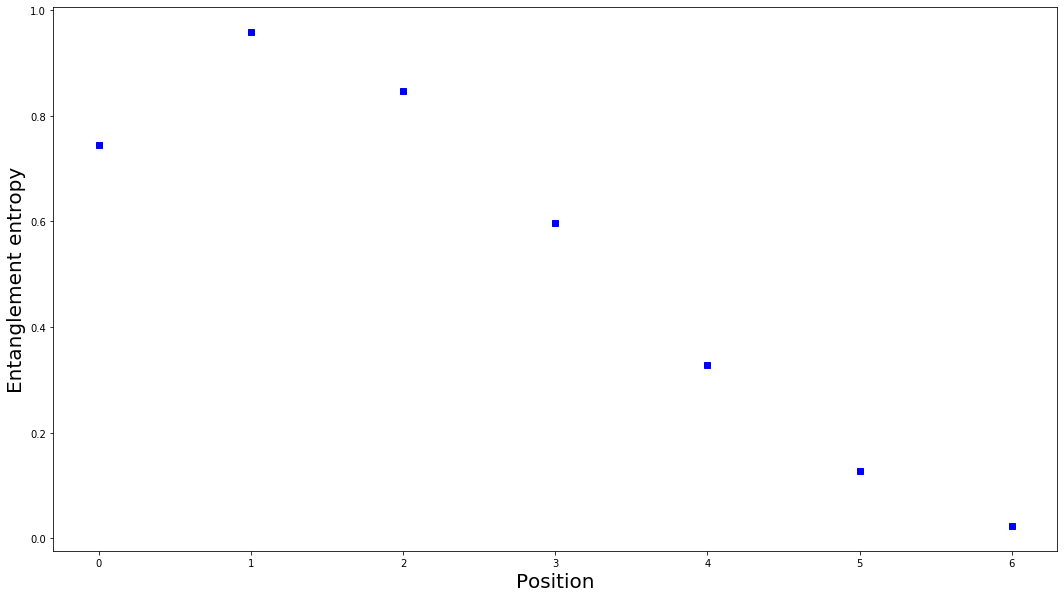

Sweep: 1 of 30, Energy: 0.019918, Bond dim: 32
Sweep: 2 of 30, Energy: 0.019709, Bond dim: 32
Sweep: 3 of 30, Energy: 0.019602, Bond dim: 32
Sweep: 4 of 30, Energy: 0.019531, Bond dim: 32
Sweep: 5 of 30, Energy: 0.019478, Bond dim: 32
Sweep: 6 of 30, Energy: 0.019437, Bond dim: 32
Sweep: 7 of 30, Energy: 0.019404, Bond dim: 32
Sweep: 8 of 30, Energy: 0.019376, Bond dim: 32
Sweep: 9 of 30, Energy: 0.019353, Bond dim: 32
Sweep: 10 of 30, Energy: 0.019333, Bond dim: 32
Sweep: 11 of 30, Energy: 0.019316, Bond dim: 32
Sweep: 12 of 30, Energy: 0.019302, Bond dim: 32
Sweep: 13 of 30, Energy: 0.019288, Bond dim: 32
Sweep: 14 of 30, Energy: 0.019277, Bond dim: 32
Sweep: 15 of 30, Energy: 0.019266, Bond dim: 32
Sweep: 16 of 30, Energy: 0.019256, Bond dim: 32
Sweep: 17 of 30, Energy: 0.019247, Bond dim: 32
Sweep: 18 of 30, Energy: 0.019239, Bond dim: 32
Sweep: 19 of 30, Energy: 0.019232, Bond dim: 32
Sweep: 20 of 30, Energy: 0.019225, Bond dim: 32
Sweep: 21 of 30, Energy: 0.019218, Bond dim: 32
S

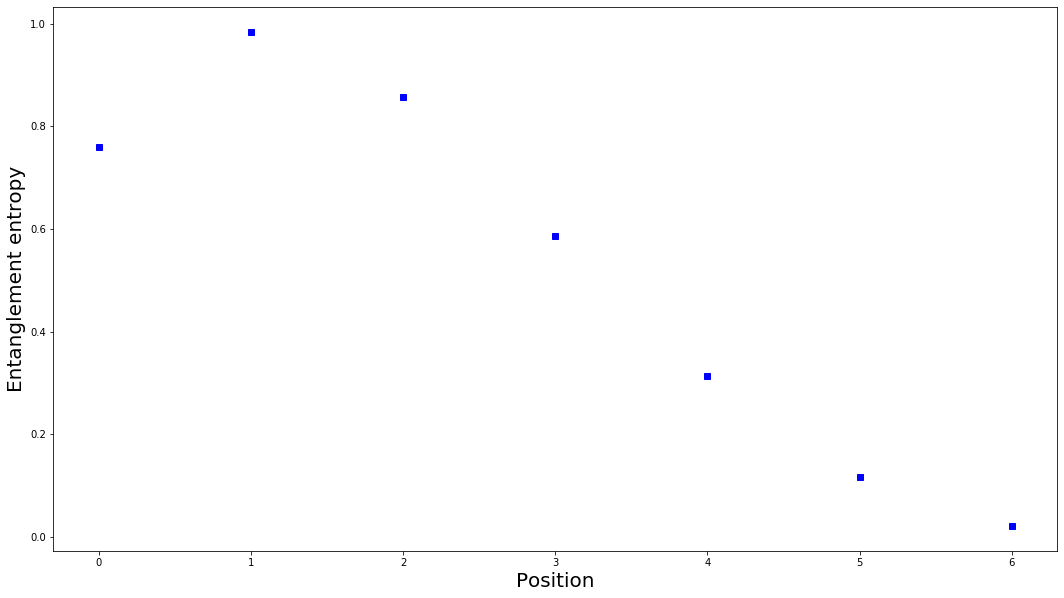

Sweep: 1 of 30, Energy: 0.018668, Bond dim: 64
Sweep: 2 of 30, Energy: 0.018554, Bond dim: 64
Sweep: 3 of 30, Energy: 0.018501, Bond dim: 64
Sweep: 4 of 30, Energy: 0.018466, Bond dim: 64
Sweep: 5 of 30, Energy: 0.018440, Bond dim: 64
Sweep: 6 of 30, Energy: 0.018420, Bond dim: 64
Sweep: 7 of 30, Energy: 0.018404, Bond dim: 64
Sweep: 8 of 30, Energy: 0.018390, Bond dim: 64
Sweep: 9 of 30, Energy: 0.018379, Bond dim: 64
Sweep: 10 of 30, Energy: 0.018369, Bond dim: 64
Sweep: 11 of 30, Energy: 0.018361, Bond dim: 64
Sweep: 12 of 30, Energy: 0.018354, Bond dim: 64
Sweep: 13 of 30, Energy: 0.018348, Bond dim: 64
Sweep: 14 of 30, Energy: 0.018342, Bond dim: 64
Sweep: 15 of 30, Energy: 0.018337, Bond dim: 64
Sweep: 16 of 30, Energy: 0.018333, Bond dim: 64
Sweep: 17 of 30, Energy: 0.018329, Bond dim: 64
Sweep: 18 of 30, Energy: 0.018326, Bond dim: 64
Sweep: 19 of 30, Energy: 0.018322, Bond dim: 64
Sweep: 20 of 30, Energy: 0.018319, Bond dim: 64
Sweep: 21 of 30, Energy: 0.018317, Bond dim: 64
S

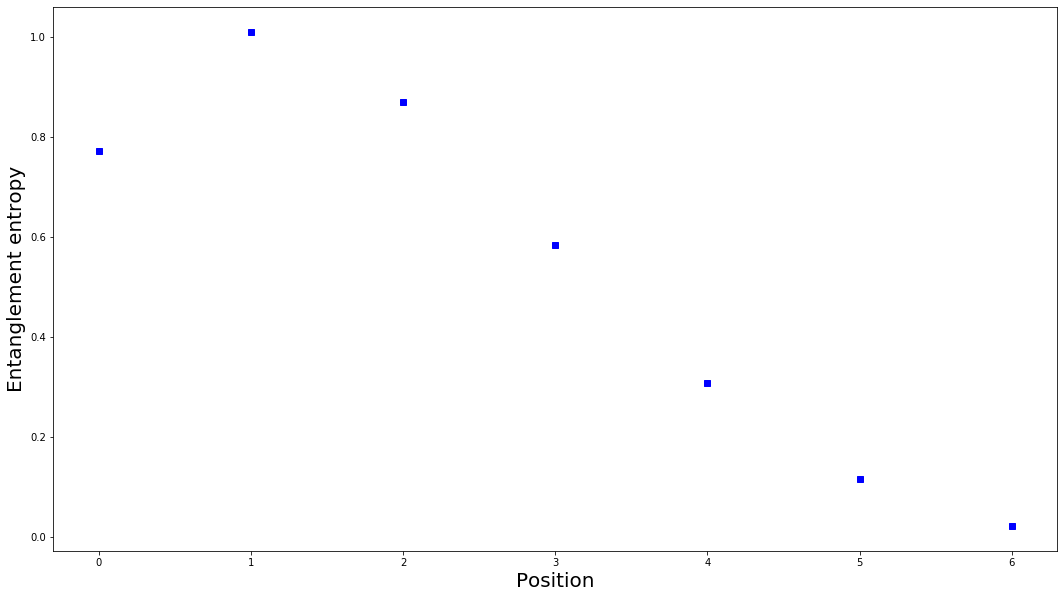

Mininimal value of the functional
0.018300283652322853



In [50]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 4
N = 20
#print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 30 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 50

#printentrhdensmatr()

#printentrlocdensmatr()

h = 0.5
CalculateEnergy()
#h = 0.1
#CalculateEnergy()
#h = 0.7
#CalculateEnergy()